In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob 
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def parse_ravdess_filename(filename):
    parts = filename.replace(".wav", "").split("-")
    emotion_code = parts[2]
    actor_id = int(parts[6])
    gender = "female" if actor_id % 2 == 0 else "male"
    
    emotions = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fear",
        "07": "disgust",
        "08": "surprised"
    }
    
    return {
        "source": "ravdess",
        "emotion": emotions.get(emotion_code, "unknown"),
        "gender": gender
    }

def parse_emodb_filename(filename):
    filename = filename.replace(".wav", "")
    emotion_code = filename[5]
    gender_code = filename[6]
    
    emotions = {
        "W": "angry",
        "L": "boredom",
        "E": "disgust",
        "A": "fear",
        "F": "happy",
        "T": "sad",
        "N": "neutral"
    }
    
    gender = "female" if gender_code == "a" else "male"
    
    return {
        "source": "emodb",
        "emotion": emotions.get(emotion_code, "unknown"),
        "gender": gender
    }


In [3]:
def load_audio_metadata_from_folder(path, source):
    data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                if source == "ravdess":
                    meta = parse_ravdess_filename(file)
                elif source == "emodb":
                    meta = parse_emodb_filename(file)
                else:
                    continue
                meta["filename"] = file
                meta["full_path"] = os.path.join(root, file)
                data.append(meta)
    return pd.DataFrame(data)


# Charger les datasets
df_ravdess = load_audio_metadata_from_folder("RAVDESS", "ravdess")
df_emodb = load_audio_metadata_from_folder("EmoDB/wav", "emodb")

# Grouper et compter pour EmoDB
count_emodb = df_emodb.groupby(["emotion", "gender"]).size().unstack(fill_value=0)
count_emodb["Total"] = count_emodb.sum(axis=1)
count_emodb.loc["Total général"] = count_emodb.sum()

# Grouper et compter pour RAVDESS
count_ravdess = df_ravdess.groupby(["emotion", "gender"]).size().unstack(fill_value=0)
count_ravdess["Total"] = count_ravdess.sum(axis=1)
count_ravdess.loc["Total général"] = count_ravdess.sum()

# Afficher les deux tableaux
print("📊 Tableau de comptage - EmoDB")
count_emodb





📊 Tableau de comptage - EmoDB


gender,female,male,Total
emotion,,,
angry,43,84,127
boredom,27,54,81
disgust,18,28,46
fear,21,48,69
happy,17,54,71
neutral,26,53,79
sad,18,44,62
Total général,170,365,535


In [4]:
print("\n📊 Tableau de comptage - RAVDESS")
count_ravdess


📊 Tableau de comptage - RAVDESS


gender,female,male,Total
emotion,,,
angry,192,192,384
calm,192,192,384
disgust,192,192,384
fear,192,192,384
happy,192,192,384
neutral,96,96,192
sad,192,192,384
surprised,192,192,384
Total général,1440,1440,2880


In [5]:
# Visualisation améliorée des comptages par émotion et genre pour EmoDB sans "Total général"
fig_emodb = px.bar(
    count_emodb_filtered.T,
    x=count_emodb_filtered.T.index,
    y=count_emodb_filtered.T.columns,
    title="Distribution des émotions par sexe - EmoDB",
    labels={"value": "Nombre d'échantillons", "emotion": "Émotion", "gender": "Genre"},
    barmode="stack",
    height=500,
    color_discrete_sequence=px.colors.qualitative.Set2  # Palette de couleurs améliorée
)

# Mise à jour des paramètres de mise en page
fig_emodb.update_layout(
    xaxis_title="Émotion",
    yaxis_title="Nombre d'échantillons",
    title_font_size=20,
    legend_title="Émotions",
    font=dict(size=14),
    legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5)  # Positionnement de la légende
)

fig_emodb.show()

# Préparer les données pour le pie chart
pie_data_emodb = count_emodb_filtered["Total"].reset_index()
pie_data_emodb.columns = ["emotion", "count"]

# Créer le graphique en camembert
fig_pie_emodb = px.pie(
    pie_data_emodb,
    names="emotion",
    values="count",
    title="Répartition des émotions - EmoDB",
    color_discrete_sequence=px.colors.qualitative.Set2  # Palette de couleurs
)

# Afficher le graphique
fig_pie_emodb.show()


NameError: name 'count_emodb_filtered' is not defined

In [83]:
# Filtrer les données pour enlever la ligne "Total général"
count_ravdess_filtered = count_ravdess[count_ravdess.index != col]

# Visualisation améliorée des comptages par émotion et genre pour RAVDESS
fig_ravdess = px.bar(
    count_ravdess_filtered.T,
    x=count_ravdess_filtered.T.index,
    y=count_ravdess_filtered.T.columns,
    title="Distribution des émotions par sexe - RAVDESS",
    labels={"value": "Nombre d'échantillons", "emotion": "Émotion", "gender": "Genre"},
    barmode="stack",
    height=500,
    color_discrete_sequence=px.colors.qualitative.Set2  # Palette de couleurs améliorée
)

# Mise à jour des paramètres de mise en page
fig_ravdess.update_layout(
    xaxis_title="Émotion",
    yaxis_title="Nombre d'échantillons",
    title_font_size=20,
    legend_title="Émotions",
    font=dict(size=14),
    legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5)  # Positionnement de la légende
)

fig_ravdess.show()

# Préparer les données pour le pie chart
pie_data = count_ravdess_filtered["Total"].reset_index()
pie_data.columns = ["emotion", "count"]

# Créer le graphique en camembert
fig_pie = px.pie(
    pie_data,
    names="emotion",
    values="count",
    title="Répartition des émotions - RAVDESS",
    color_discrete_sequence=px.colors.qualitative.Set2  # Palette de couleurs
)

# Afficher le graphique
fig_pie.show()

Playing EmoDB audio example: EmoDB\wav\03a01Fa.wav


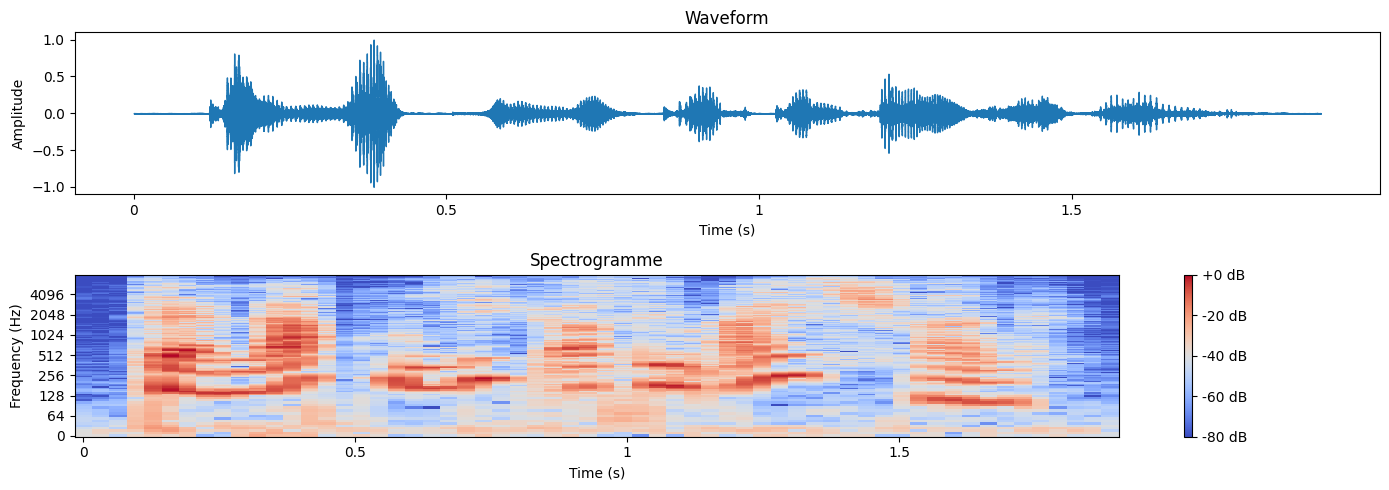

Playing RAVDESS audio example: RAVDESS\Actor_01\03-01-01-01-01-01-01.wav


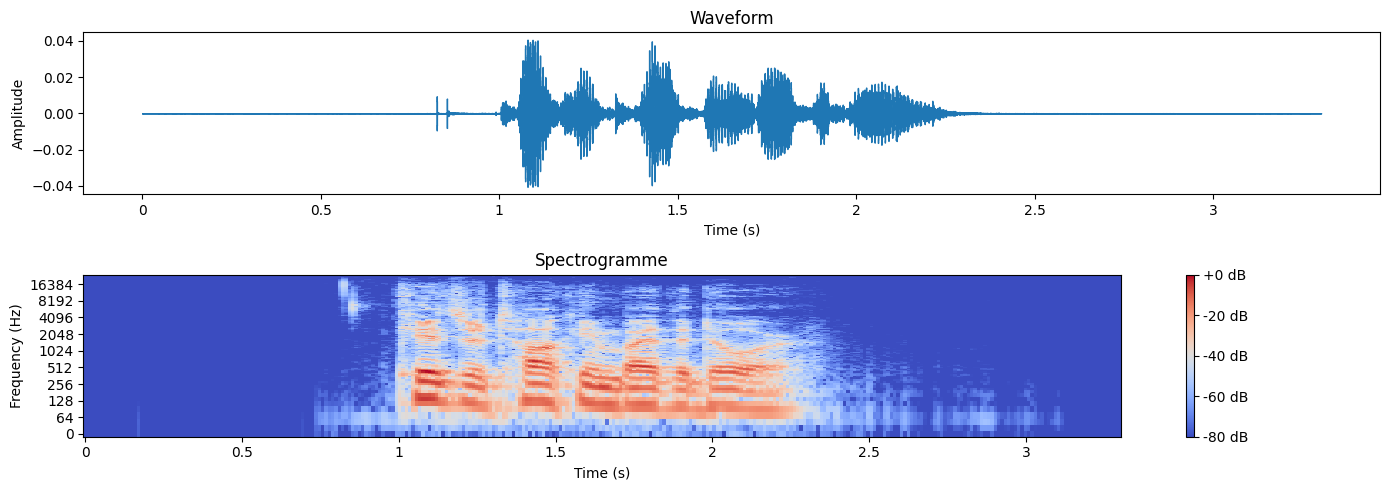

In [86]:
# Plot pour EmoDB
print(f"Playing EmoDB audio example: {example_emodb_audio}")
ipd.display(ipd.Audio(example_emodb_audio))
plot_audio_example(example_emodb_audio, sr=sr_emodb)

# Plot pour RAVDESS
print(f"Playing RAVDESS audio example: {example_ravdess_audio}")
ipd.display(ipd.Audio(example_ravdess_audio))
plot_audio_example(example_ravdess_audio, sr=sr_ravdess)

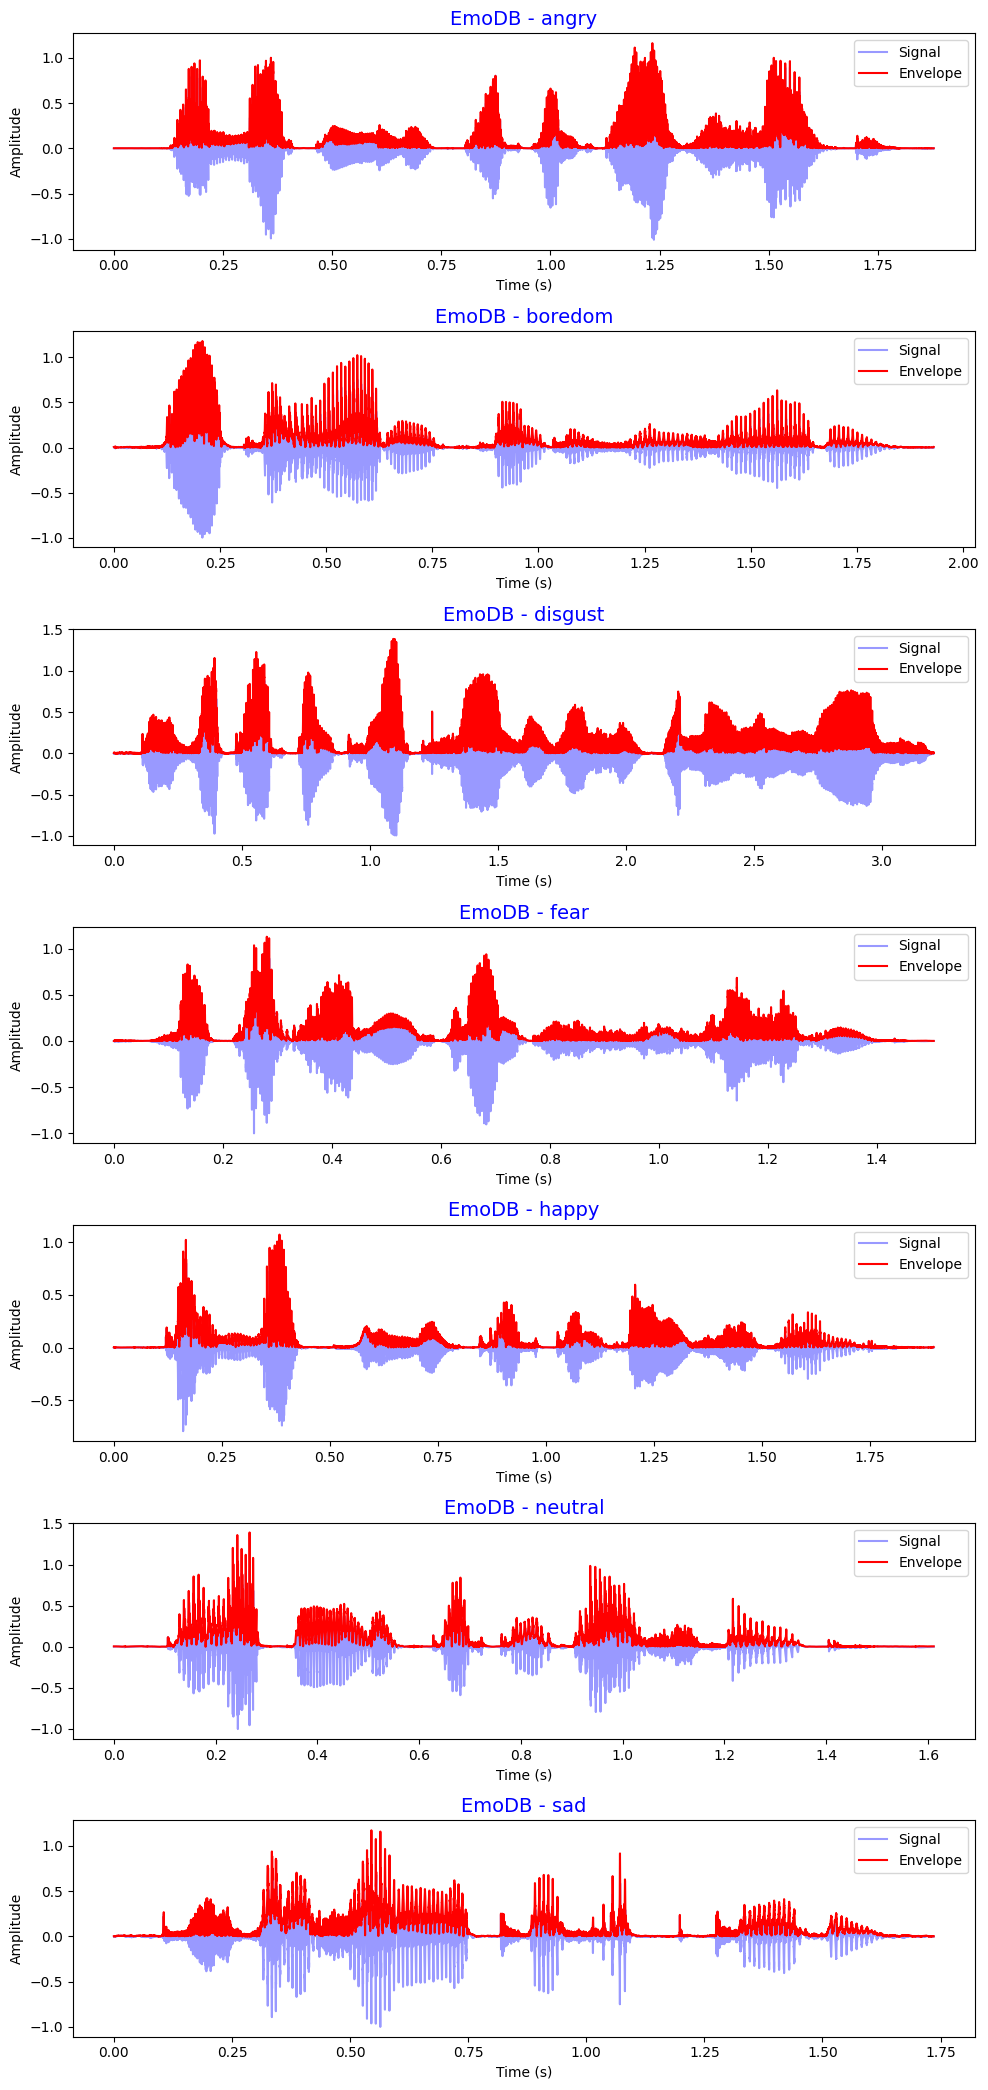

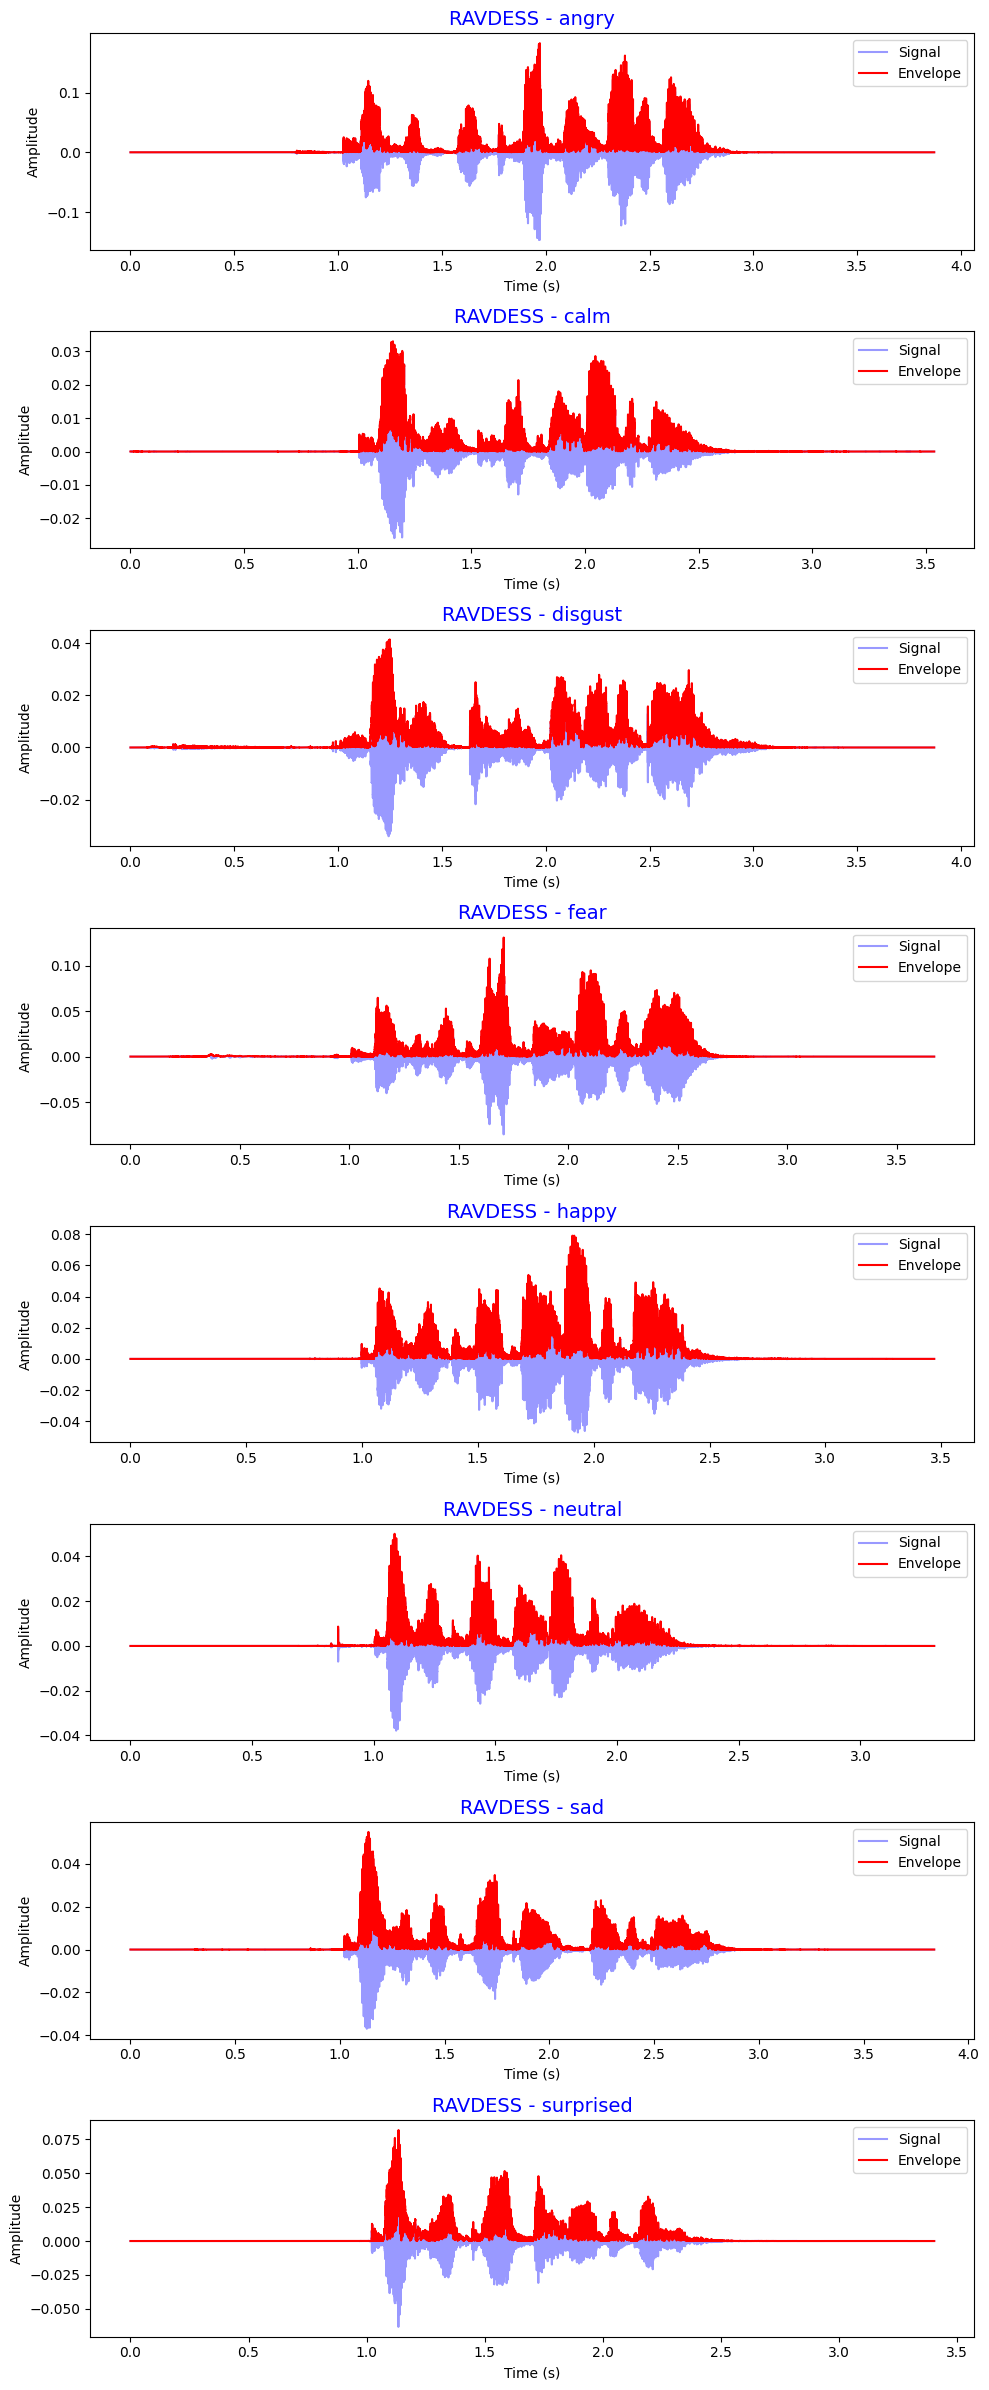

In [21]:
from scipy.signal import hilbert

def plot_waveform_with_precise_envelope(audio_path, title, ax):
    y, sr = librosa.load(audio_path)
    
    # Calculer l'enveloppe analytique avec la transformée de Hilbert
    analytic_signal = hilbert(y)
    envelope = np.abs(analytic_signal)
    
    # Tracer le signal audio et son enveloppe
    ax.plot(np.linspace(0, len(y)/sr, len(y)), y, alpha=0.4, color='blue', label='Signal')
    ax.plot(np.linspace(0, len(y)/sr, len(envelope)), envelope, color='red', label='Envelope')
    ax.set_title(title, fontsize=14, color='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()

# Exemple d'utilisation pour EmoDB
fig_emodb, axes_emodb = plt.subplots(
    nrows=len(df_emodb['emotion'].unique()), 
    ncols=1, 
    figsize=(10, 3 * len(df_emodb['emotion'].unique()))
)

for ax, (emotion, group) in zip(axes_emodb, df_emodb.groupby('emotion')):
    audio_path = group.iloc[0]['full_path']  # Utiliser le premier fichier pour chaque émotion
    plot_waveform_with_precise_envelope(audio_path, f"EmoDB - {emotion}", ax)

plt.tight_layout()
plt.show()

# Exemple d'utilisation pour RAVDESS
fig_ravdess, axes_ravdess = plt.subplots(
    nrows=len(df_ravdess['emotion'].unique()), 
    ncols=1, 
    figsize=(10, 3 * len(df_ravdess['emotion'].unique()))
)

for ax, (emotion, group) in zip(axes_ravdess, df_ravdess.groupby('emotion')):
    audio_path = group.iloc[0]['full_path']  # Utiliser le premier fichier pour chaque émotion
    plot_waveform_with_precise_envelope(audio_path, f"RAVDESS - {emotion}", ax)

plt.tight_layout()
plt.show()


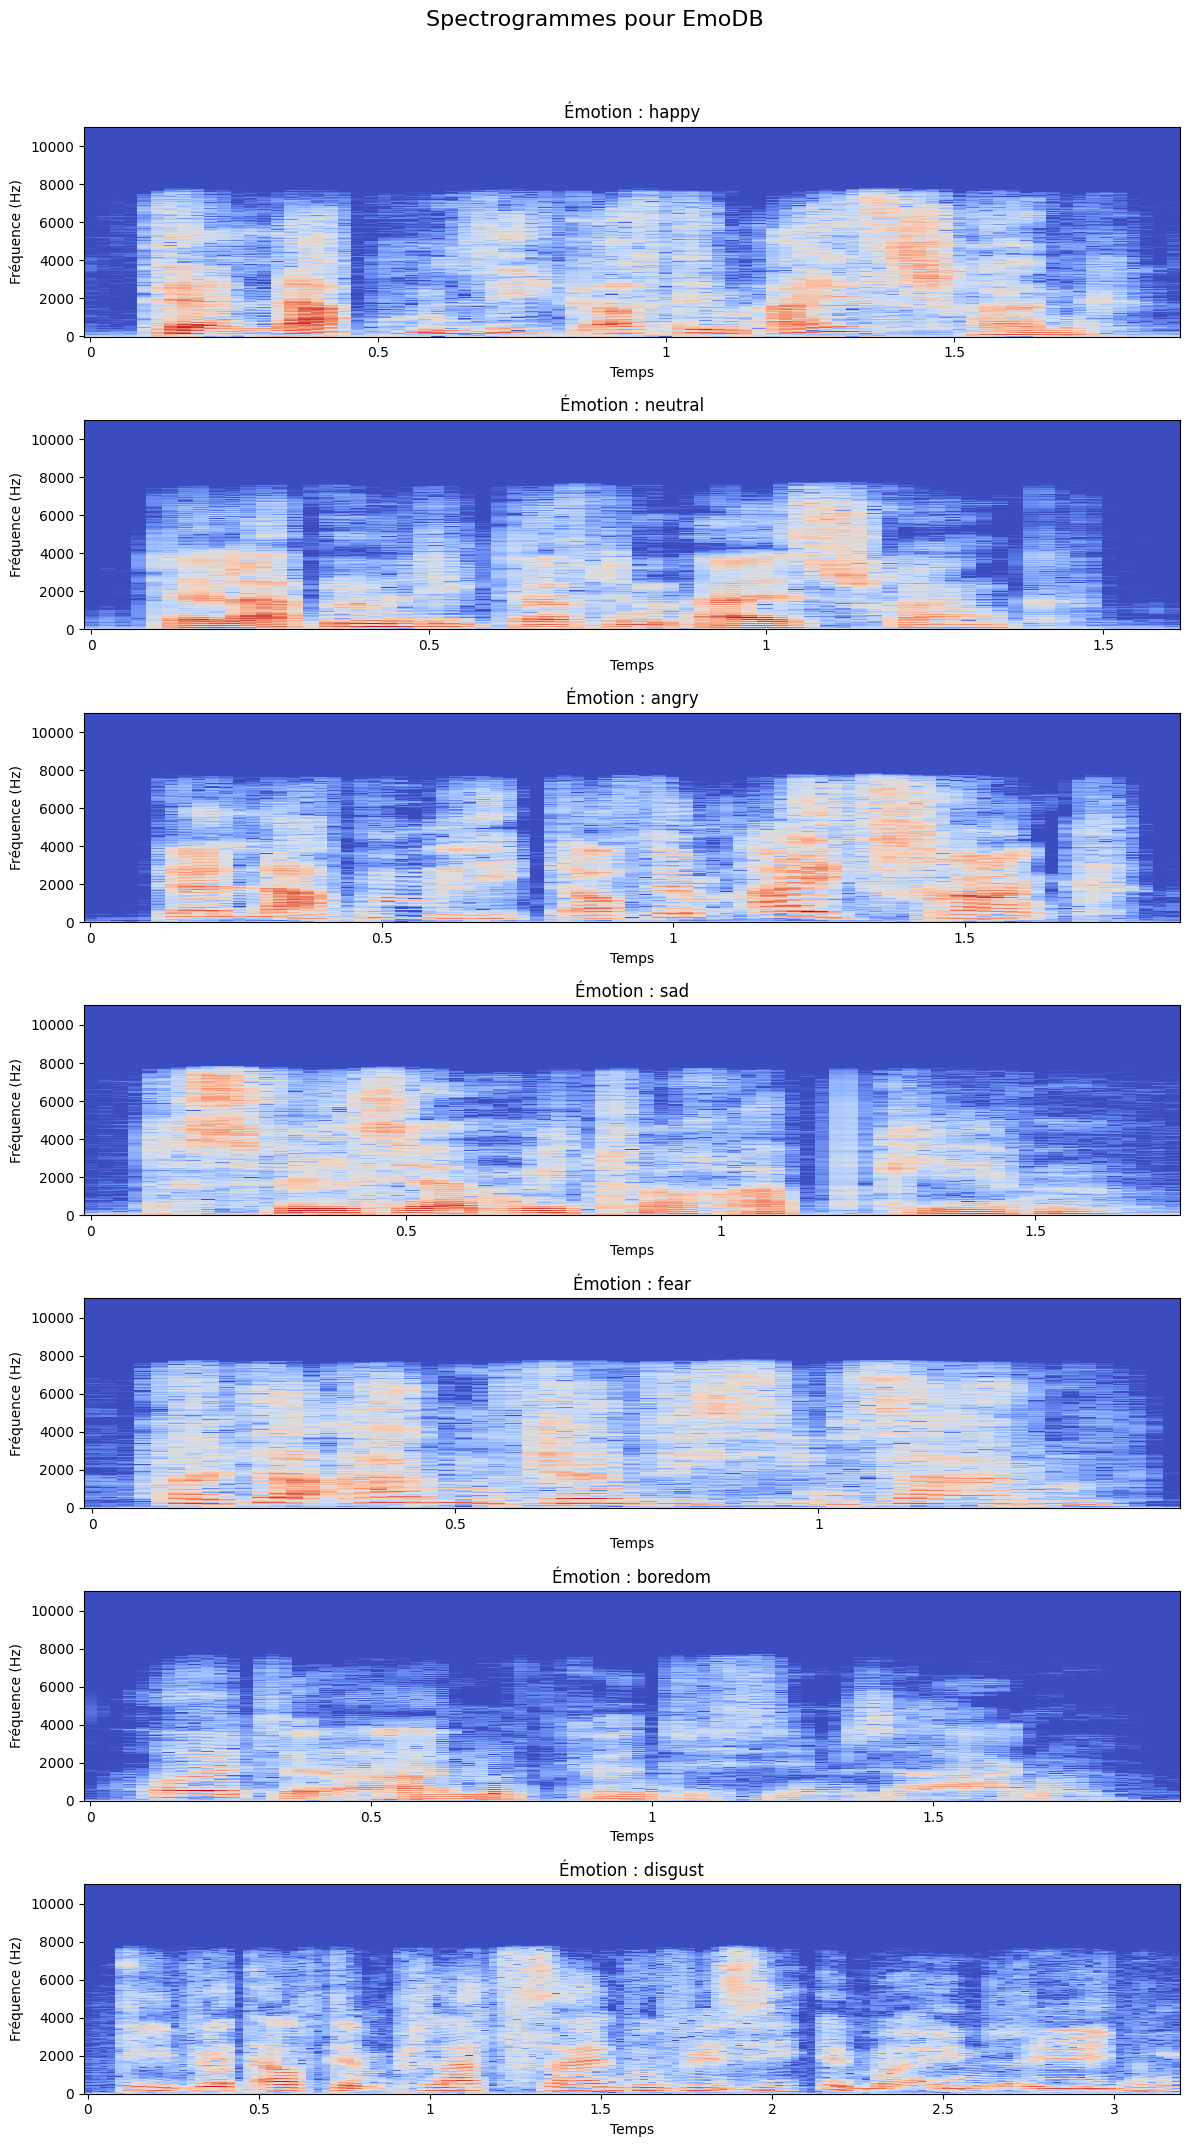

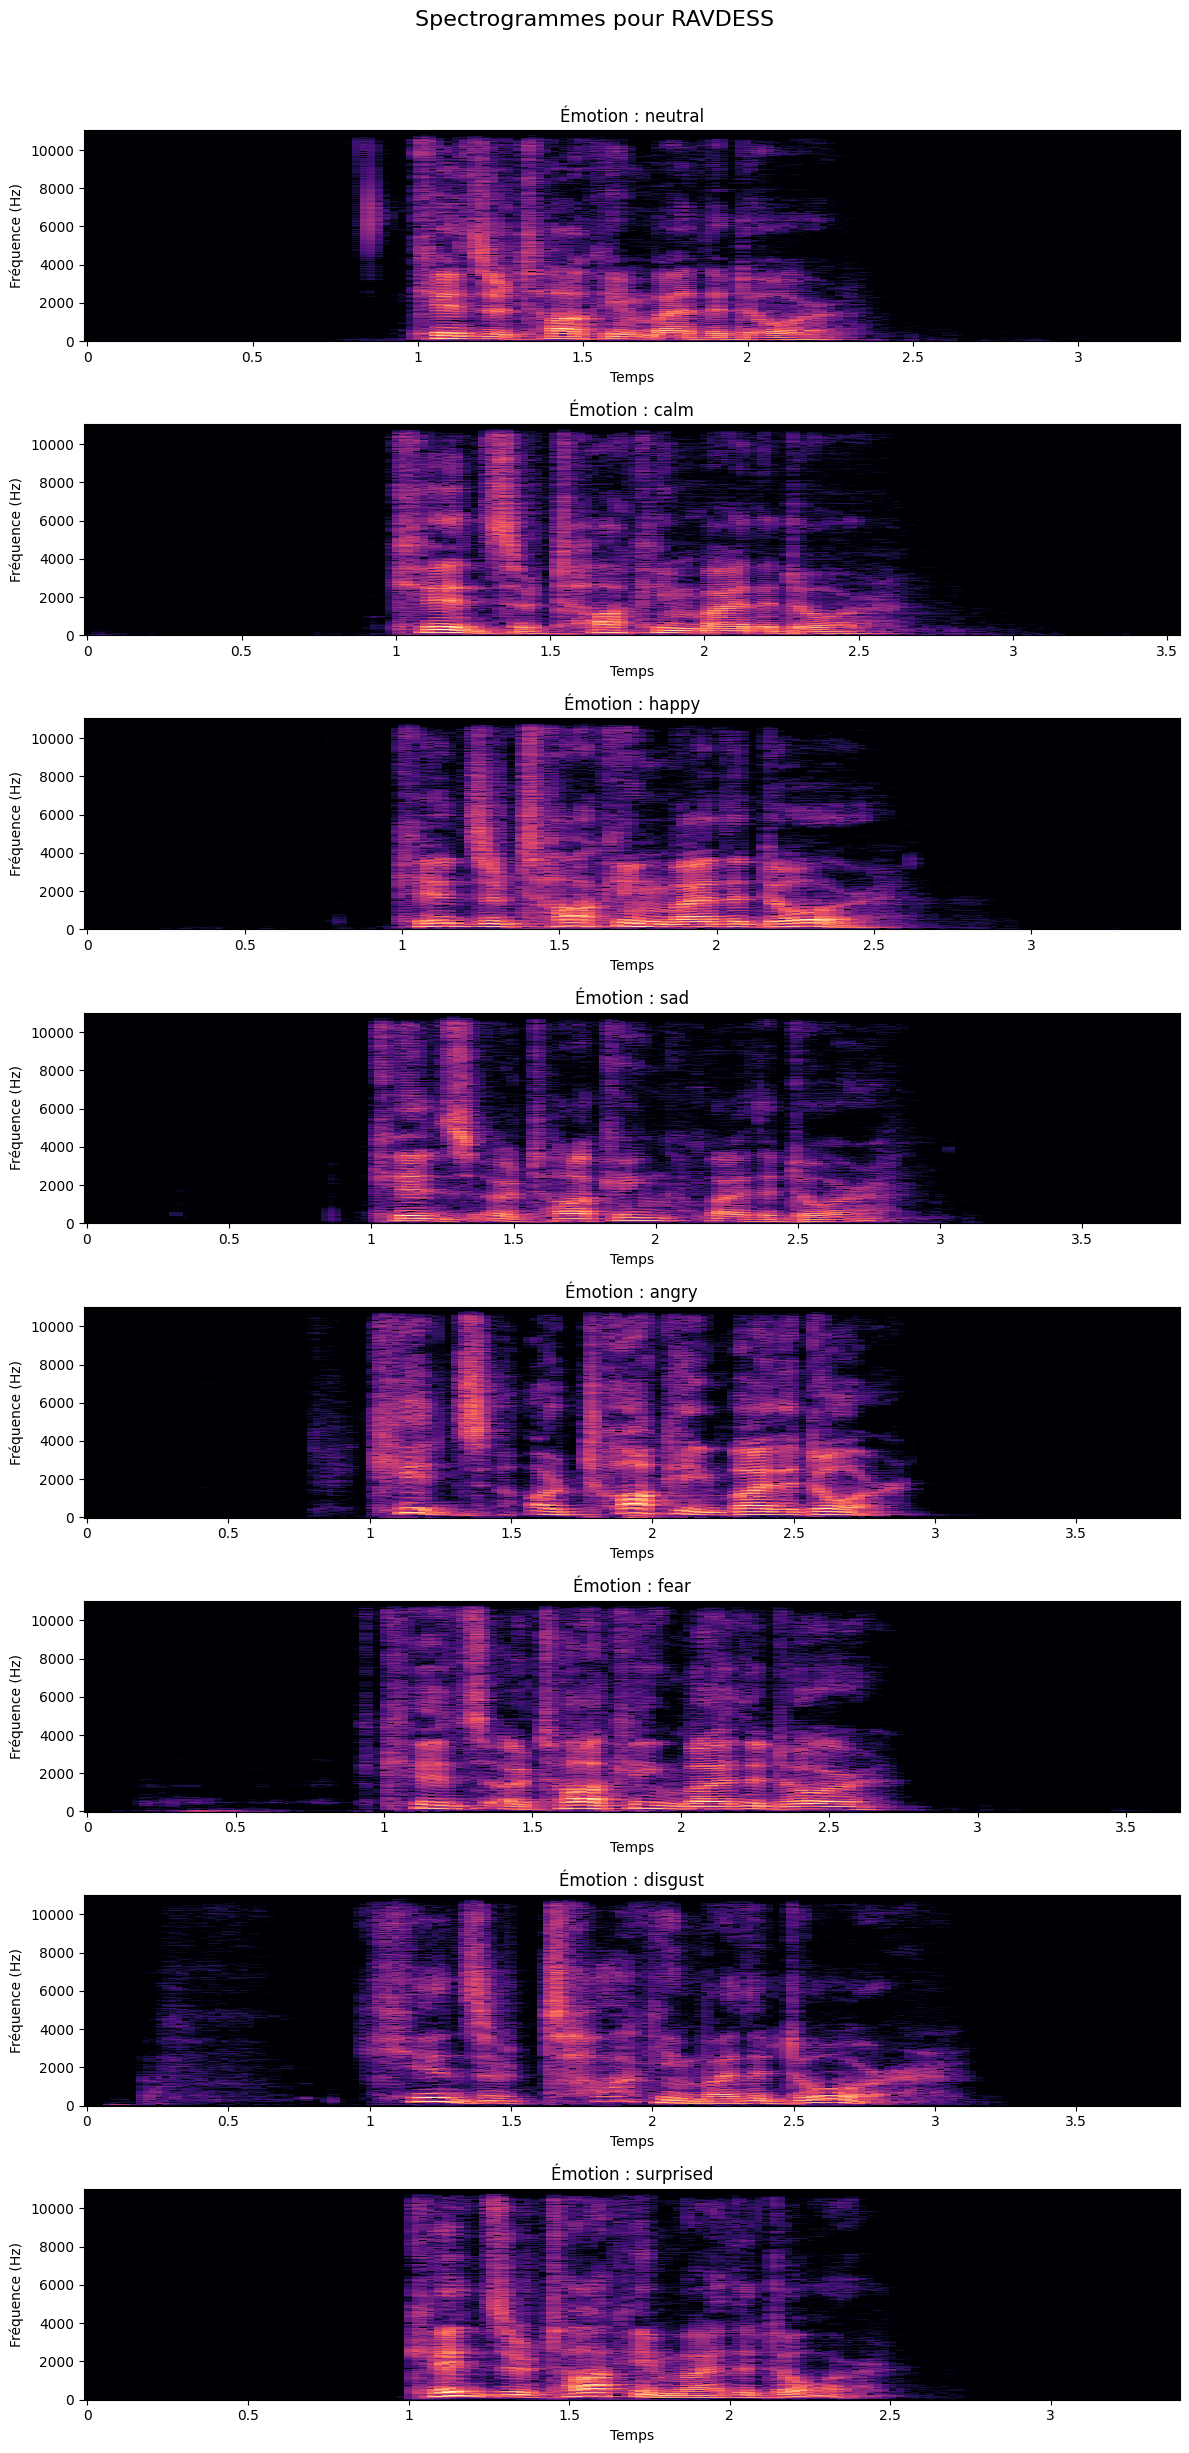

In [23]:
def create_spectrogram_grid(dataset, dataset_name):
    unique_emotions = dataset['emotion'].unique()
    num_emotions = len(unique_emotions)
    
    fig, axes = plt.subplots(nrows=num_emotions, ncols=1, figsize=(12, 3 * num_emotions))
    fig.suptitle(f"Spectrogrammes pour {dataset_name}", fontsize=16, y=1.02)
    
    for ax, emotion in zip(axes, unique_emotions):
        # Charger le premier fichier audio pour chaque émotion
        emotion_group = dataset[dataset['emotion'] == emotion]
        audio_path = emotion_group.iloc[0]['full_path']
        audio_data, sample_rate = librosa.load(audio_path)
        
        # Créer le spectrogramme
        X = librosa.stft(audio_data)
        Xdb = librosa.amplitude_to_db(abs(X))
        
        librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz', ax=ax)
        ax.set_title(f"Émotion : {emotion}", fontsize=12)
        ax.set_xlabel("Temps")
        ax.set_ylabel("Fréquence (Hz)")
    
    plt.tight_layout()
    plt.show()

# Créer les grilles pour EmoDB et RAVDESS
create_spectrogram_grid(df_emodb, "EmoDB")
create_spectrogram_grid(df_ravdess, "RAVDESS")

# Data Preprocessing

In [50]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Fonction pour extraire les caractéristiques audio
def resample_audio(audio_path, target_sample_rate=22050):
    y, sr = librosa.load(audio_path, sr=None)
    if sr != target_sample_rate:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sample_rate)
    return y, target_sample_rate, sr   



#  Normalisation de la durée des échantillons

In [ ]:
# Normalisation de la durée des échantillons
def pad_or_truncate_audio(audio_data, target_length=10, sample_rate=22050):
    target_samples = target_length * sample_rate
    if len(audio_data) < target_samples:
        padding = target_samples - len(audio_data)
        audio_data = np.pad(audio_data, (0, padding), mode='constant')
    else:
        audio_data = audio_data[:target_samples]
    return audio_data

#  Conversion en mel-spectrogrammes

In [ ]:
# convertir l'audio en spectrogramme Mel
def audio_to_mel_spectrogram(audio_data, sample_rate, hop_length=256, n_fft=1024):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length
    )
    
    # Convertir en dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

# Z-score Normalization

In [ ]:
def z_score_normalization(mel_spectrogram):
    mean = np.mean(mel_spectrogram)
    std = np.std(mel_spectrogram)
    return (mel_spectrogram - mean) / std


# Pipeline sur un dataset

In [41]:
# ------------------------
# Pipeline sur un dataset
# ------------------------
def process_dataset(df, dataset_name):
    summary = []
    processed_data = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {dataset_name}"):
        file_path = row['full_path']
        emotion = row['emotion']
        gender = row.get('gender', 'Unknown')

        try:
            audio_data, new_sr, original_sr = resample_audio(file_path)
            duration = len(audio_data) / new_sr

            padded_audio = pad_or_truncate_audio(audio_data, sample_rate=new_sr)
            mel_spec = audio_to_mel_spectrogram(padded_audio, sample_rate=new_sr)
            mel_spec_norm = z_score_normalization(mel_spec)

            processed_data.append(mel_spec_norm)

            summary.append({
                'Dataset': dataset_name,
                'Emotion': emotion,
                'Original SR': original_sr,
                'Final SR': new_sr,
                'Original Duration (s)': round(duration, 2),
                'Final Duration (s)': 10,
                'Mel Spec Shape': mel_spec.shape
            })

        except Exception as e:
            print(f"Error with file {file_path}: {e}")
            continue

    return pd.DataFrame(summary), processed_data


# Traitement des datasets

In [42]:
# Traitement des datasets
summary_emodb, processed_emodb = process_dataset(df_emodb, "EmoDB")
summary_ravdess, processed_ravdess = process_dataset(df_ravdess, "RAVDESS")


Processing RAVDESS: 100%|██████████| 2880/2880 [01:22<00:00, 34.95it/s]


In [49]:

def summarize_table(summary_df):
    summary = summary_df.groupby(['Dataset', 'Emotion']).agg(
        Count=('Emotion', 'count'),
        Original_SR=('Original SR', 'first'),
        Final_SR=('Final SR', 'first'),
        Original_Duration=('Original Duration (s)', 'mean'),
        Final_Duration=('Final Duration (s)', 'mean')
    ).reset_index()
    return summary

final_summary = pd.concat([summary_emodb, summary_ravdess], ignore_index=True)
final_table = summarize_table(final_summary)


In [46]:
# Séparer les tableaux
emodb_table = final_table[final_table['Dataset'] == 'EmoDB']
ravdess_table = final_table[final_table['Dataset'] == 'RAVDESS']

# Affichage
print("===== EmoDB Summary =====")
emodb_table


===== EmoDB Summary =====


,Dataset,Emotion,Count,Original_SR,Final_SR,Original_Duration,Final_Duration
0,EmoDB,angry,127,16000,22050,2.640630,10.0
1,EmoDB,boredom,81,16000,22050,2.779259,10.0
2,EmoDB,disgust,46,16000,22050,3.352826,10.0
3,EmoDB,fear,69,16000,22050,2.233043,10.0
4,EmoDB,happy,71,16000,22050,2.543662,10.0
5,EmoDB,neutral,79,16000,22050,2.359367,10.0
6,EmoDB,sad,62,16000,22050,4.053226,10.0


In [48]:
print("===== EmoDB Summary =====")
ravdess_table

===== EmoDB Summary =====


,Dataset,Emotion,Count,Original_SR,Final_SR,Original_Duration,Final_Duration
7,RAVDESS,angry,384,48000,22050,3.870625,10.0
8,RAVDESS,calm,384,48000,22050,3.795365,10.0
9,RAVDESS,disgust,384,48000,22050,3.941302,10.0
10,RAVDESS,fear,384,48000,22050,3.574063,10.0
11,RAVDESS,happy,384,48000,22050,3.637813,10.0
12,RAVDESS,neutral,192,48000,22050,3.503333,10.0
13,RAVDESS,sad,384,48000,22050,3.694115,10.0
14,RAVDESS,surprised,384,48000,22050,3.487865,10.0
